**Test of the Gaussian Quadrature**  

References:
- sections 7.2 and 7.5 *in* **Judd, Kenneth L. (1998)**. Numerical Methods in Economics. MIT Press.  
- details of the implementation in `GH_Quadrature.pdf`.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import grsam

Instanciation

In [2]:
portf = grsam.Portfolio(horizon=50)
portf.standard_initialization()

print("Bivariate distribution")
print(f" mean vector: {portf.mean}")
print(f" covariance matrix: {portf.cov[0,:]}")
print(f"                    {portf.cov[1,:]}")
print("Prior over the mean vector")
print(f" mean vector: {portf.mean_belief_init}")
print(f" covariance matrix: {portf.cov_belief_init[0,:]}")
print(f"                    {portf.cov_belief_init[1,:]}")

Bivariate distribution
 mean vector: [0.08 0.08]
 covariance matrix: [0.04 0.02]
                    [0.02 0.04]
Prior over the mean vector
 mean vector: [0.13 0.13]
 covariance matrix: [0.004 0.   ]
                    [0.   0.01]


Initialize the quadrature nodes' positions and weights for `n_Gauss` nodes.

In [3]:
portf.init_GaussHermite(n_Gauss=11)

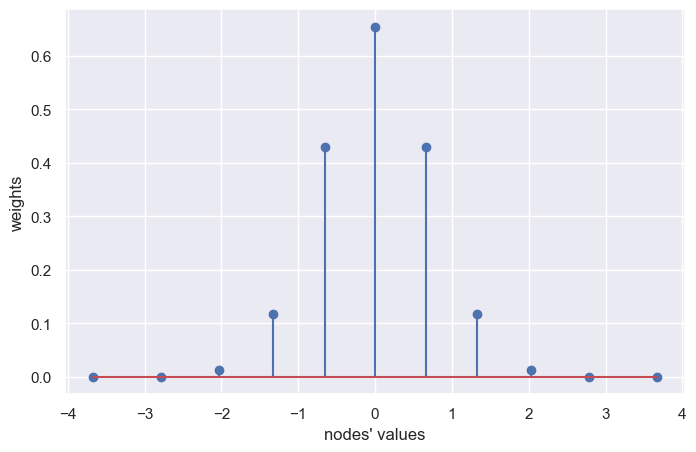

In [4]:
def plot_GH_nodes():
    fig, ax = plt.subplots(figsize=(8,5))
    ax.stem(portf.x_gauss, portf.w_gauss)
    ax.set_xlabel("nodes' values")
    ax.set_ylabel("weights")

plot_GH_nodes()

Compute the values of the nodes for the bivariate distribution

In [5]:
portf.init_corr_nodes(cov=portf.cov)
portf.init_corr_nodes_double(cov_outer=portf.cov_belief_init)

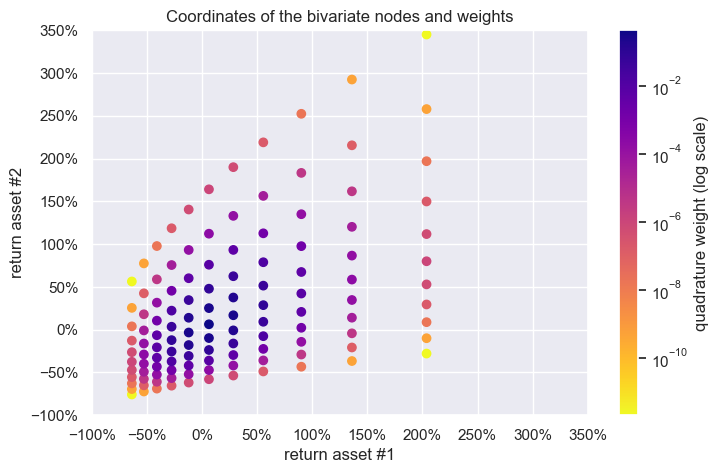

In [6]:
def plot_GH_nodes_scaled():
    R1 = np.exp(portf.mean[0] + portf.R1_s) - portf.rf
    R2 = np.exp(portf.mean[1] + portf.R2_s) - portf.rf
    weights = portf.W_n1 * portf.W_n2
    fig, ax = plt.subplots(figsize=(8,5))
    paths = ax.scatter(R1.ravel(), R2.ravel(), c=weights, cmap='plasma_r', norm="log")
    ax.set_xlabel("return asset #1")
    ax.set_ylabel("return asset #2")
    ax.set_xlim([-1, 3.5])
    ax.set_ylim([-1, 3.5])
    ax.xaxis.set_major_formatter(mtick.PercentFormatter(1))
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
    ax.set_title("Coordinates of the bivariate nodes and weights")
    fig.colorbar(paths, label="quadrature weight (log scale)")

plot_GH_nodes_scaled()

# Tests of the GH Quadrature

## Test of the simple quadrature for the bivariate Normal vector

In [7]:
def test_simple_quadrature():
    E1 = portf.mean[0]
    E2 = portf.mean[1]
    var1 = portf.cov[0,0] 
    cov = portf.cov[0,1]
    R1 = E1 + portf.R1_s
    R2 = E2 + portf.R2_s
    
    print("E[X1]")
    E = portf.outer_quadrature(R1)
    print(f"Theoretical value:{E1}, quadrature:{E:.8f}")
    
    print("E[(X1)^2] = Var[X1] + (E[X1])^2")
    E = portf.outer_quadrature(R1**2)
    print(f"Theoretical value:{var1+E1**2:.8f}, quadrature:{E:.8f}")

    print("E[X1+X2] = E[X1]+E[X2]")
    E = portf.outer_quadrature(R1+R2)
    print(f"Theoretical value:{E1+E2:.8f}, quadrature:{E:.8f}")

    print("E[X1X2] = Cov(X1,X2) + E[X1]E[X2]")
    E = portf.outer_quadrature(R1*R2)
    print(f"Theoretical value:{cov+E1*E2:.8f}, quadrature:{E:.8f}")

test_simple_quadrature()

E[X1]
Theoretical value:0.08, quadrature:0.08000000
E[(X1)^2] = Var[X1] + (E[X1])^2
Theoretical value:0.04640000, quadrature:0.04640000
E[X1+X2] = E[X1]+E[X2]
Theoretical value:0.16000000, quadrature:0.16000000
E[X1X2] = Cov(X1,X2) + E[X1]E[X2]
Theoretical value:0.02640000, quadrature:0.02640000


## Test of the double quadrature with Normal Bayesian prior 

The random vector is $\mathcal{N}(m, \Sigma)$ with $\mu \sim \mathcal{N}(\mu, \Lambda)$.  
The predictive probability is $\mathcal{N}(\mu, \Sigma+\Lambda)$

In [8]:
def test_double_quadrature():
    E1 = portf.mean_belief_init[0]
    E2 = portf.mean_belief_init[1]
    var1 = portf.cov[0,0] + portf.cov_belief_init[0,0]
    cov = portf.cov[0,1] + portf.cov_belief_init[0,1]
    R1 = E1 + portf.R1_d
    R2 = E2 + portf.R2_d
    
    print("E[X1]")
    Exp_inner = portf.inner_quadrature(R1)
    Exp_outer = portf.outer_quadrature(Exp_inner)
    print(f"Theoretical value:{E1}, quadrature:{Exp_outer:.8f}")
    
    print("E[(X1)^2] = Var[X1] + (E[X1])^2")
    Exp_inner = portf.inner_quadrature(R1**2)
    Exp_outer = portf.outer_quadrature(Exp_inner)
    print(f"Theoretical value:{var1+E1**2:.8f}, quadrature:{Exp_outer:.8f}")

    print("E[X1+X2] = E[X1]+E[X2]")
    Exp_inner = portf.inner_quadrature(R1+R2)
    Exp_outer = portf.outer_quadrature(Exp_inner)
    print(f"Theoretical value:{E1+E2:.8f}, quadrature:{Exp_outer:.8f}")

    print("E[X1X2] = Cov(X1,X2) + E[X1]E[X2]")
    Exp_inner = portf.inner_quadrature(R1*R2)
    Exp_outer = portf.outer_quadrature(Exp_inner)
    print(f"Theoretical value:{cov+E1*E2:.8f}, quadrature:{Exp_outer:.8f}")

test_double_quadrature()

E[X1]
Theoretical value:0.13, quadrature:0.13000000
E[(X1)^2] = Var[X1] + (E[X1])^2
Theoretical value:0.06090000, quadrature:0.06090000
E[X1+X2] = E[X1]+E[X2]
Theoretical value:0.26000000, quadrature:0.26000000
E[X1X2] = Cov(X1,X2) + E[X1]E[X2]
Theoretical value:0.03690000, quadrature:0.03690000
